In [543]:
import numpy as np
import pandas as pd

In [544]:
#!ls ../data/isic-2024-challenge/

In [545]:
train = pd.read_csv("train_metadata.csv")
test = pd.read_csv("test_metadata.csv")

In [546]:
train.shape

(320847, 41)

In [547]:
y = train["target"]

In [548]:
test.shape

(80212, 41)

Test has fewer columns than train - only use the intersection so that we can apply to test data <br>

In [549]:
shared_cols = set(train.columns).intersection(set(test.columns))
len(shared_cols)

41

Use second line in the next cell if you want to use all columns instead.

In [550]:
# train_trim = train[list(shared_cols)]
train_trim = train.drop("target", axis=1)
train_trim.shape

(320847, 40)

String columns

In [551]:
len(train_trim.select_dtypes(include="object").columns)

5

Number columns

In [552]:
len(train_trim.select_dtypes(include="number").columns)

35

Null checking

In [553]:
nulls = train_trim.apply(lambda col: col.isnull().sum() / col.size * 100)
nulls.head()

id                        0.000000
age_approx                0.694100
sex                       2.875514
anatom_site_general       1.435264
clin_size_long_diam_mm    0.000000
dtype: float64

Columns with nulls

In [554]:
nulls[nulls > 0]

age_approx             0.694100
sex                    2.875514
anatom_site_general    1.435264
dtype: float64

Dropping rows with null age. Sex handled later, anatom_site_general not used.

In [555]:
train_trim = train_trim.dropna(subset=['age_approx'])

Extract string columns

In [556]:
string_cols = train_trim.select_dtypes(include="object")
string_cols.head()

,sex,anatom_site_general,tbp_tile_type,tbp_lv_location,tbp_lv_location_simple
0,male,upper extremity,3D: white,Left Arm - Lower,Left Arm
1,female,posterior torso,3D: XP,Torso Back Middle Third,Torso Back
2,female,lower extremity,3D: XP,Left Leg - Upper,Left Leg
3,female,upper extremity,3D: white,Left Arm - Lower,Left Arm
4,male,posterior torso,3D: XP,Torso Back Top Third,Torso Back


Check for constant-value columns

In [557]:
string_cols.apply(lambda row: row.unique())

sex                                                     [male, female, nan]
anatom_site_general       [upper extremity, posterior torso, lower extre...
tbp_tile_type                                           [3D: white, 3D: XP]
tbp_lv_location           [Left Arm - Lower, Torso Back Middle Third, Le...
tbp_lv_location_simple    [Left Arm, Torso Back, Left Leg, Torso Front, ...
dtype: object

Drop ID and other useless string columns

In [558]:
to_drop = ["tbp_tile_type", "copyright_license", "isic_id", "patient_id", "attribution", "image_type"]
set(string_cols.columns).difference(set(to_drop))

{'anatom_site_general', 'sex', 'tbp_lv_location', 'tbp_lv_location_simple'}

3 location columns, increasing specificity. Using the middle one for one-hot encoding

In [559]:
string_cols["anatom_site_general"].value_counts()

anatom_site_general
posterior torso    96839
lower extremity    81711
anterior torso     69630
upper extremity    56224
head/neck           9624
Name: count, dtype: int64

In [560]:
string_cols["tbp_lv_location_simple"].value_counts()

tbp_lv_location_simple
Torso Back     96839
Torso Front    69630
Left Leg       42204
Right Leg      39507
Left Arm       28952
Right Arm      27272
Head & Neck     9624
Unknown         4592
Name: count, dtype: int64

In [561]:
string_cols["tbp_lv_location"].value_counts()

tbp_lv_location
Torso Back Top Third       56565
Torso Front Top Half       50365
Torso Back Middle Third    36617
Left Leg - Lower           21854
Right Leg - Lower          19955
Torso Front Bottom Half    19223
Left Leg - Upper           18768
Right Arm - Upper          18359
Left Arm - Upper           18241
Right Leg - Upper          18195
Head & Neck                 9624
Left Arm - Lower            9457
Right Arm - Lower           8445
Unknown                     4592
Torso Back Bottom Third     3650
Left Leg                    1582
Right Leg                   1357
Left Arm                    1254
Right Arm                    468
Torso Front                   42
Torso Back                     7
Name: count, dtype: int64

One-hot encoding the sex column. Using a vector of length 2 here to account for the NaaNs - when the value is "unknown", the vector is [0, 0]. Alternatively, we could drop all NaaN rows and use a single indicator column.

In [562]:
male_indicator = string_cols["sex"].apply(lambda s: float(s == "male" and not s == "unknown"))
male_indicator.name = "Male"
female_indicator = string_cols["sex"].apply(lambda s: float(s == "female" and not s == "unknown"))
female_indicator.name = "Female"

In [563]:
numerical_sex = pd.concat([male_indicator, female_indicator], axis=1)
numerical_sex.tail()

,Male,Female
320842,0.0,0.0
320843,1.0,0.0
320844,1.0,0.0
320845,1.0,0.0
320846,1.0,0.0


One-hot encoding the location column

In [564]:
one_hot_location = pd.Series(string_cols["tbp_lv_location_simple"].value_counts().index[:-1]).apply(
    lambda location: string_cols["tbp_lv_location_simple"].apply(lambda loc: float(loc == location))).transpose()
one_hot_location.columns = string_cols["tbp_lv_location_simple"].value_counts().index[:-1]
one_hot_location.head()


tbp_lv_location_simple,Torso Back,Torso Front,Left Leg,Right Leg,Left Arm,Right Arm,Head & Neck
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Total one-hot encoded columns

In [565]:
one_hot_combined = pd.concat([numerical_sex, one_hot_location], axis=1)
one_hot_combined.head()

,Male,Female,Torso Back,Torso Front,Left Leg,Right Leg,Left Arm,Right Arm,Head & Neck
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Normalizing other numerical columns to the [0, 1] range with min-max scaling

In [566]:
numerical = train_trim.select_dtypes(include="number")

for column in numerical.columns: 
    numerical[column] = (numerical[column] - numerical[column].min()) / (numerical[column].max() - numerical[column].min())     

Concat with numerical columns to get the clean data

In [567]:
clean = pd.concat([one_hot_combined, numerical], axis=1)
clean.head()

,Male,Female,Torso Back,Torso Front,Left Leg,Right Leg,Left Arm,Right Arm,Head & Neck,id,...,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,...,0.320724,0.045869,0.102839,0.129462,0.061593,0.192391,0.257143,0.149702,0.776402,0.514450
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000003,...,0.274954,0.046672,0.088264,0.154240,0.052280,0.259906,0.371429,0.456182,0.714228,0.656138
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000006,...,0.433906,0.118826,0.107364,0.289794,0.048338,0.114581,0.000000,0.323607,0.620132,0.524953
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000009,...,0.165085,0.052959,0.043202,0.142073,0.070101,0.218593,0.514286,0.149161,0.745858,0.452957
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000012,...,0.417430,0.083788,0.132387,0.074718,0.054687,0.442235,0.000000,0.416389,0.771198,0.311479


In [568]:
probs = pd.read_csv("vit_train_probabilities.csv")

In [569]:
clean.shape

(318620, 44)

In [570]:
clean.index

Index([     0,      1,      2,      3,      4,      5,      6,      7,      8,
            9,
       ...
       320837, 320838, 320839, 320840, 320841, 320842, 320843, 320844, 320845,
       320846],
      dtype='int64', length=318620)

In [571]:
clean_index_as_float = clean.index.astype(float)
filtered_probs = probs[probs["id"].isin(clean_index_as_float)]

In [572]:
clean = pd.concat([clean, probs], axis = 1).drop(columns=["id"])

Save the clean data

In [573]:
# clean.to_csv("../../../clean_train-metadata.csv", index=False)

In [574]:
y = y[clean.index]

### Distribution Adjustment

In [575]:
from sklearn.utils.class_weight import compute_class_weight

df = pd.concat([clean, y], axis=1)

#Handle Class Imbalance
print("Class Distribution Before Sampling (%):")
display(df.target.value_counts(normalize=True)*100)
seed = 1

T = 0.13
N = 1 - T
# Desired distribution
# N, T = 0.90, 0.20  # for a 70:30 split

# Current counts
neg_count = df.query("target == 0").shape[0]
pos_count = df.query("target == 1").shape[0]

# Calculate sampling fractions
pos_sample = 1.0
neg_sample = (N * pos_count) / (T * neg_count)

# Sampling
positive_df = df.query("target==0").sample(frac=neg_sample, random_state=seed)
negative_df = df.query("target==1").sample(frac=pos_sample, replace=False, random_state=seed)
df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0)

print("\nClass Distribution After Sampling (%):")
display(df.target.value_counts(normalize=True)*100)

# Assume df is your DataFrame and 'target' is the column with class labels
class_weights = compute_class_weight('balanced', classes=np.unique(df['target']), y=df['target'])
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Distribution Before Sampling (%):


target
0    99.902134
1     0.097866
Name: proportion, dtype: float64


Class Distribution After Sampling (%):


target
0    86.99793
1    13.00207
Name: proportion, dtype: float64

Class Weights: {0: np.float64(0.5747263207996193), 1: np.float64(3.8455414012738856)}


In [576]:
x = df.drop("target", axis=1)
y = df["target"]
y.value_counts()

target
0    2101
1     314
Name: count, dtype: int64

In [577]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=42)

In [578]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
booster = xgb.XGBClassifier()
booster.fit(X_train, y_train)
y_pred = booster.predict(X_test)
y_test = y_test.to_numpy()

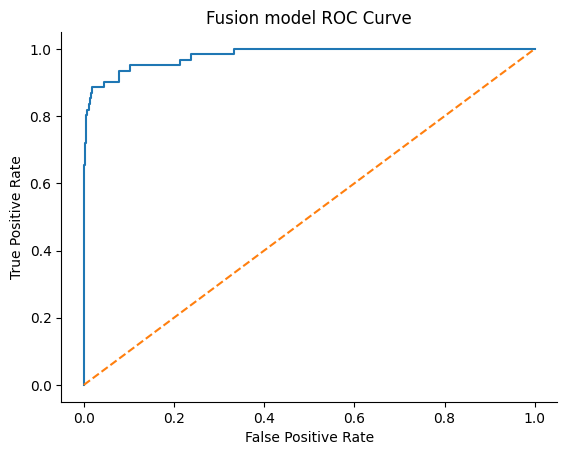

In [579]:
from sklearn.metrics import roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
y_probs = booster.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Fusion model ROC Curve")
plt.plot(np.linspace(0, 1.0, 10000),
         np.linspace(0, 1.0, 10000), linestyle="dashed")
sns.despine()

### Accuracy

In [580]:
np.mean(y_pred == y_test)

np.float64(0.9668737060041408)

### AUC

In [581]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_pred)
auc

np.float64(0.917935669334162)

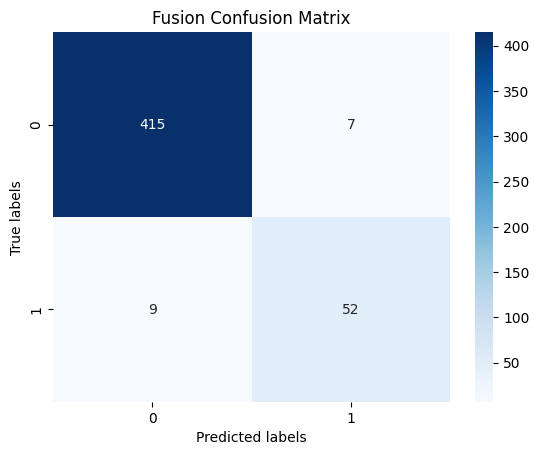

In [582]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, y_pred)
labels = np.unique(y_pred + y_test)
sns.heatmap(matrix, annot=True, fmt="d", xticklabels=labels[:-1], yticklabels=labels[:-1], cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Fusion Confusion Matrix")
plt.show()

Tabular Model 

In [583]:
x_tabular = x.iloc[:, :-2]
X_train, X_test, y_train, y_test = train_test_split(x_tabular, y, test_size=0.2,random_state=42)

In [584]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
booster = xgb.XGBClassifier()
booster.fit(X_train, y_train)
y_pred = booster.predict(X_test)
y_test = y_test.to_numpy()

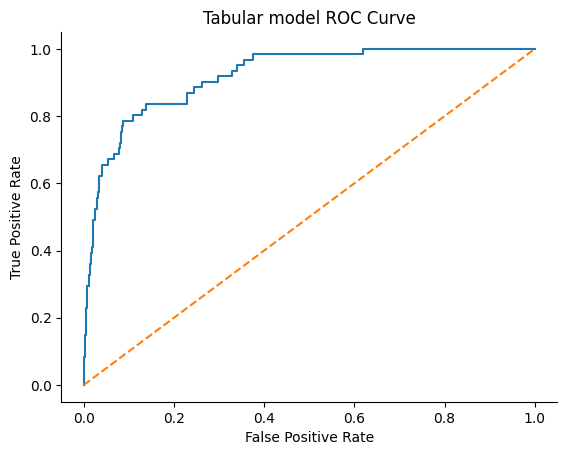

In [585]:
y_probs = booster.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Tabular model ROC Curve")
plt.plot(np.linspace(0, 1.0, 10000),
         np.linspace(0, 1.0, 10000), linestyle="dashed")
sns.despine()

In [586]:
np.mean(y_pred == y_test)

np.float64(0.9151138716356108)

In [587]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_pred)
auc

np.float64(0.7480770724885402)

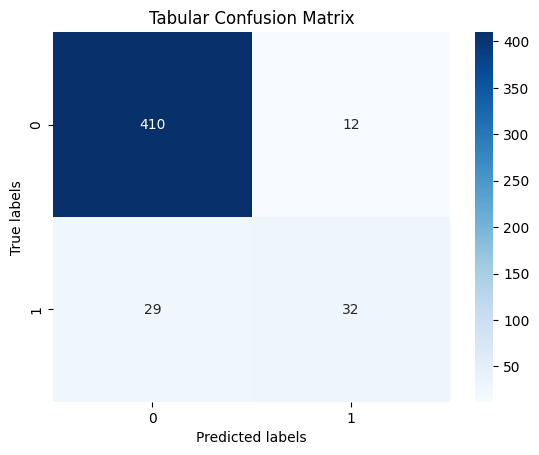

In [588]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, y_pred)
labels = np.unique(y_pred + y_test)
sns.heatmap(matrix, annot=True, fmt="d", xticklabels=labels[:-1], yticklabels=labels[:-1], cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Tabular Confusion Matrix")
plt.show()